In [1]:
import sqlite3
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
import math
import matplotlib.pyplot as plt
import warnings
import numpy as np
import pyodbc 
warnings.simplefilter('ignore')

In [2]:
DB = {'servername': 'LAPTOP-LPE28RPE\SQLEXPRESS', 
    'database': 'United_outdoors'}

export_conn = pyodbc.connect('DRIVER={SQL Server};SERVER=' + DB['servername'] + 
                              ';DATABASE=' + DB['database'])

export_cursor = export_conn.cursor()
export_cursor  

In [3]:

Adventure = {
    'servername' : 'LAPTOP-LPE28RPE\SQLEXPRESS',
    'database' : 'AdventureWorks2019'
}


Northwind = {
    'servername' : 'LAPTOP-LPE28RPE\SQLEXPRESS',
    'database' : 'Northwind'
}

access_db_path = r'C:\Users\Humberto de Castro\OneDrive\Desktop\SEM4\AenC\aenc.accdb'

#Connect to AdventureWorks
Adventure_conn = pyodbc.connect(f"DRIVER={{SQL Server}};SERVER={Adventure['servername']};DATABASE={Adventure['database']};Trusted_Connection=yes;")
Adventure_cursor = Adventure_conn.cursor()

#Connect to Northwind
Northwind_conn = pyodbc.connect(f"DRIVER={{SQL Server}};SERVER={Northwind['servername']};DATABASE={Northwind['database']};Trusted_Connection=yes;")
Northwind_cursor = Northwind_conn.cursor()

#Connect to AenC
AenC_conn = pyodbc.connect(f"DRIVER={{Microsoft Access Driver (*.mdb, *.accdb)}};DBQ={access_db_path};")



In [4]:
AdventureWorks_queries = {
    'AW_Customer' : 'SELECT * FROM Sales.Customer',
    'Person' : 'SELECT * FROM Person.Person',
    'BusinessEntity' : 'SELECT * FROM Person.BusinessEntity',
    'BusinessEntityAddress' : 'SELECT * FROM Person.BusinessEntityAddress',
    'PersonAddress' : 'SELECT * FROM Person.Address',
    'StateProvince' : 'SELECT * FROM Person.StateProvince',
    'CountryRegion' : 'SELECT * FROM Person.CountryRegion',
    'Territory' : 'SELECT * FROM Sales.SalesTerritory',
    'PersonPhone' : 'SELECT * FROM Person.PersonPhone',
    'Store' : 'SELECT * FROM Sales.Store'
}

Northwind_queries = {
    'NW_Customer' : 'SELECT * FROM Customers'
}

AenC_queries = {
    'state' : 'SELECT * FROM state',  # Add state table query
    'AC_Customer' : 'SELECT * FROM Customer',  # Add Customer table query
    'region' : 'SELECT * FROM region'
}

dataframes = {}

# Lees elke tabel in een DataFrame

for table_name, query in AdventureWorks_queries.items():
    dataframes[table_name] = pd.read_sql_query(query, Adventure_conn)

for table_name, query in Northwind_queries.items():
    dataframes[table_name] = pd.read_sql_query(query, Northwind_conn)

for table_name, query in AenC_queries.items():
    dataframes[table_name] = pd.read_sql_query(query, AenC_conn)

#als je ik elk tabel als een dataframe/ variabele wil behandelen of aanroepen moet ik dit uitvoeren.
for table_name, df in dataframes.items():
    globals()[table_name] = df


### Customer

AdventureWorks

In [5]:
# Drop duplicate columns before merging
columns_to_drop = ['rowguid', 'ModifiedDate']

# Drop duplicate columns if they exist in the DataFrames
Person = Person.drop(columns=[col for col in columns_to_drop if col in Person.columns])
BusinessEntityAddress = BusinessEntityAddress.drop(columns=[col for col in columns_to_drop if col in BusinessEntityAddress.columns])
PersonAddress = PersonAddress.drop(columns=[col for col in columns_to_drop if col in PersonAddress.columns])
StateProvince = StateProvince.drop(columns=[col for col in columns_to_drop if col in StateProvince.columns])
CountryRegion = CountryRegion.drop(columns=[col for col in columns_to_drop if col in CountryRegion.columns])
Territory = Territory.drop(columns=[col for col in columns_to_drop if col in Territory.columns])
Store = Store.drop(columns=[col for col in columns_to_drop if col in Store.columns])
PersonPhone = PersonPhone.drop(columns=[col for col in columns_to_drop if col in PersonPhone.columns])

# Drop additional duplicate columns from AW_Customer
AW_Customer = AW_Customer.drop(columns=[col for col in columns_to_drop if col in AW_Customer.columns])

# Now perform the merge operations
AW_Customer = pd.merge(AW_Customer, Person, left_on='PersonID', right_on='BusinessEntityID', suffixes=('', '_person'))
AW_Customer = pd.merge(AW_Customer, PersonPhone, on='BusinessEntityID', suffixes=('', '_phone'))
AW_Customer = pd.merge(AW_Customer, BusinessEntityAddress, on='BusinessEntityID', suffixes=('', '_business'))
AW_Customer = pd.merge(AW_Customer, PersonAddress, left_on='AddressID', right_on='AddressID', suffixes=('', '_personaddress'))
AW_Customer = pd.merge(AW_Customer, StateProvince, left_on='StateProvinceID', right_on='StateProvinceID', suffixes=('', '_stateprovince'))
AW_Customer = pd.merge(AW_Customer, CountryRegion, left_on='CountryRegionCode', right_on='CountryRegionCode', suffixes=('', '_countryregion'))
AW_Customer = pd.merge(AW_Customer, Territory, left_on='TerritoryID', right_on='TerritoryID', suffixes=('', '_Territory'))

print(AW_Customer)

       CustomerID  PersonID  StoreID  TerritoryID AccountNumber  \
0           11000   13531.0      NaN            9    AW00011000   
1           11001    5454.0      NaN            9    AW00011001   
2           11002   11269.0      NaN            9    AW00011002   
3           11003   11358.0      NaN            9    AW00011003   
4           11004   11901.0      NaN            9    AW00011004   
...           ...       ...      ...          ...           ...   
18503       29479    4191.0      NaN            7    AW00029479   
18504       29480    4472.0      NaN           10    AW00029480   
18505       29481    8168.0      NaN            8    AW00029481   
18506       29482   12570.0      NaN            7    AW00029482   
18507       29483   18384.0      NaN            7    AW00029483   

       BusinessEntityID PersonType  NameStyle Title  FirstName  ...  \
0                 13531         IN      False  None        Jon  ...   
1                  5454         IN      False  None  

Northwind

In [6]:
# First, fill NaN values in ContactName to avoid split issues
NW_Customer['ContactName'] = NW_Customer['ContactName'].fillna('')

# Split ContactName into FirstName and LastName safely
split_names = NW_Customer['ContactName'].str.split(n=1, expand=True)

# Ensure there are two columns after split
split_names.columns = ['FirstName', 'LastName']

# Handle cases where the split resulted in a single part
split_names['LastName'] = split_names['LastName'].fillna('')

# Assign the split names back to the DataFrame
NW_Customer[['FirstName', 'LastName']] = split_names

# Now drop the ContactName column
NW_Customer.drop(columns=['ContactName'], inplace=True)

# Check the DataFrame to ensure the operation was successful
print(NW_Customer.head())

  CustomerID                         CompanyName          ContactTitle  \
0      ALFKI                 Alfreds Futterkiste  Sales Representative   
1      ANATR  Ana Trujillo Emparedados y helados                 Owner   
2      ANTON             Antonio Moreno Taquería                 Owner   
3      AROUT                     Around the Horn  Sales Representative   
4      BERGS                  Berglunds snabbköp   Order Administrator   

                         Address         City Region PostalCode  Country  \
0                  Obere Str. 57       Berlin   None      12209  Germany   
1  Avda. de la Constitución 2222  México D.F.   None      05021   Mexico   
2                Mataderos  2312  México D.F.   None      05023   Mexico   
3                120 Hanover Sq.       London   None    WA1 1DP       UK   
4                Berguvsvägen  8        Luleå   None   S-958 22   Sweden   

            Phone             Fax  FirstName  LastName  
0     030-0074321     030-0076545      Ma

AenC

In [7]:
AC_Customer = pd.merge(AC_Customer, state, left_on = 'state', right_on = 'state_id')
AC_Customer = pd.merge(AC_Customer, region, on = 'region')

AC_Customer

,id,fname,lname,address,city,state,zip,phone,company_name,state_id,state_name,state_capital,country,region
0,101,Michaels,Devlin,3114 Pioneer Avenue,Rutherford,NJ,07070,2015558966,The Power Group,NJ,New Jersey,Trenton,USA,Eastern
1,102,Beth,Reiser,1033 Whippany Road,New York,NY,10154,2125558725,AMF Corp.,NY,New York,Albany,USA,Eastern
2,103,Erin,Niedringhaus,1990 Windsor Street,Paoli,PA,19301,2155556513,Darling Associates,PA,Pennsylvania,Harrisburg,USA,Eastern
3,104,Meghan,Mason,550 Dundas Street East,Knoxville,TN,37919,6155555463,P.S.C.,TN,Tennessee,Nashville,USA,Central
4,105,Laura,McCarthy,1210 Highway 36,Carmel,IN,46032,3175558437,Amo & Sons,IN,Indiana,Indianapolis,USA,Central
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,552,Janice,O'Toole,654 West Hill,Nashville,TN,37320,6155553689,Greensleeves,TN,Tennessee,Nashville,USA,Central
122,553,Stevie,Nickolas,77 Recordings Circle,Tacoma,WA,96521,5095551695,It's a Hit!,WA,Washington,Olympia,USA,Western
123,555,Philipe,Fernandez,99 Main Street,Los Angeles,CA,90205,2135554457,Quaker Fashions,CA,California,Sacramento,USA,Western
124,661,Jennifer,Stutzman,3 Back Pages Lane,Missola,IL,60505,7085556857,Stutzman Advertising,IL,Illinois,Springfield,USA,Central


In [8]:
print(NW_Customer)

   CustomerID                         CompanyName               ContactTitle  \
0       ALFKI                 Alfreds Futterkiste       Sales Representative   
1       ANATR  Ana Trujillo Emparedados y helados                      Owner   
2       ANTON             Antonio Moreno Taquería                      Owner   
3       AROUT                     Around the Horn       Sales Representative   
4       BERGS                  Berglunds snabbköp        Order Administrator   
..        ...                                 ...                        ...   
86      WARTH                      Wartian Herkku         Accounting Manager   
87      WELLI              Wellington Importadora              Sales Manager   
88      WHITC                White Clover Markets                      Owner   
89      WILMK                         Wilman Kala  Owner/Marketing Assistant   
90      WOLZA                      Wolski  Zajazd                      Owner   

                          Address      

In [9]:
# Rename columns in AC_Customer
AC_Customer.rename(columns={
    'id': 'CustomerID',
    'fname': 'FirstName',
    'lname': 'LastName',
    'phone': 'Phone',
    'region' : 'Region',
    'country': 'Country',
    'state' : 'State',
    'city' : 'City',
    'zip' : 'PostalCode',
    'address': 'Address',
    
}, inplace=True)

# Rename columns in NW_Customer
NW_Customer.rename(columns={
    'CustomerID': 'CustomerID',  # already correctly named
    'Region' : 'State'

}, inplace=True)
# Rename columns in AW_Customer
AW_Customer.rename(columns={
    'CustomerID': 'CustomerID',  # already correctly named
    'PhoneNumber': 'Phone',
    'Group' : 'Region',
    'CountryRegionCode' : 'Country',
    'StateProvinceCode' : 'State',
    'AddressLine1' : 'Address',

}, inplace=True)

# Verify the changes
print("AC_Customers after renaming:")
print(AC_Customer.head())
print("NW_Customer after renaming:")
print(NW_Customer.head())
print("AW_Customer after renaming:")
print(AW_Customer.head())


AC_Customers after renaming:
  CustomerID FirstName      LastName                 Address        City  \
0        101  Michaels        Devlin     3114 Pioneer Avenue  Rutherford   
1        102      Beth        Reiser      1033 Whippany Road    New York   
2        103      Erin  Niedringhaus     1990 Windsor Street       Paoli   
3        104    Meghan         Mason  550 Dundas Street East   Knoxville   
4        105     Laura      McCarthy         1210 Highway 36      Carmel   

  State PostalCode       Phone        company_name state_id    state_name  \
0    NJ      07070  2015558966     The Power Group       NJ    New Jersey   
1    NY      10154  2125558725           AMF Corp.       NY      New York   
2    PA      19301  2155556513  Darling Associates       PA  Pennsylvania   
3    TN      37919  6155555463              P.S.C.       TN     Tennessee   
4    IN      46032  3175558437          Amo & Sons       IN       Indiana   

  state_capital Country   Region  
0       Trenton 

Prefix

In [10]:
# Adding a prefix to EmployeeIDs for each source DataFrame
AW_Customer['CustomerID'] = AW_Customer['CustomerID'].apply(lambda x: f'AW_{x}')
NW_Customer['CustomerID'] = NW_Customer['CustomerID'].apply(lambda x: f'NW_{x}')
AC_Customer['CustomerID'] = AC_Customer['CustomerID'].apply(lambda x: f'AC_{x}')


mapping

In [11]:
country_mapping = {
    'Germany': 'DE',
    'Mexico': 'MX',
    'UK': 'GB',
    'Sweden': 'SE',
    'France': 'FR',
    'Spain': 'ES',
    'Canada': 'CA',
    'Argentina': 'AR',
    'Switzerland': 'CH',
    'Brazil': 'BR',
    'Austria': 'AT',
    'Portugal': 'PT',
    'Italy': 'IT',
    'Belgium': 'BE',
    'USA': 'US',  # Change 'USA' to 'US'
    'Ireland': 'IE',
    'Norway': 'NO',
    'Denmark': 'DK',
    'Finland': 'FI',
    'Poland': 'PL'
}

# Replace country names with abbreviations
NW_Customer['Country'] = NW_Customer['Country'].replace(country_mapping)

print(NW_Customer[['Country']])


   Country
0       DE
1       MX
2       MX
3       GB
4       SE
..     ...
86      FI
87      BR
88      US
89      FI
90      PL

[91 rows x 1 columns]


In [12]:
# Replace 'USA' with 'US' in the Country column
AC_Customer['Country'] = AC_Customer['Country'].replace('USA', 'US')

AC_Customer['Country'] = AC_Customer['Country'].replace('CAN', 'CA')

In [13]:
AC_Customer['Region'] = AC_Customer['Region'].replace({'south': 'Southern'})
AW_Customer['Region'] = AW_Customer['Region'].replace({'North America': 'Northern'})


In [14]:
required_columns_customer = [
    'CustomerID', 'FirstName', 'LastName', 'Phone', 'Region', 'Country', 'State', 'City', 
    'PostalCode', 'Address'
]

# Ensure all required columns exist in each Customer DataFrame
for col in required_columns_customer:
    if col not in AC_Customer.columns:
        AC_Customer[col] = None
    if col not in NW_Customer.columns:
        NW_Customer[col] = None
    if col not in AW_Customer.columns:
        AW_Customer[col] = None

# Select the columns in the correct order
AC_Customers = AC_Customer[required_columns_customer]
NW_Customer = NW_Customer[required_columns_customer]
AW_Customer = AW_Customer[required_columns_customer]


In [15]:
# Combine the DataFrames
Customer = pd.concat([AC_Customers, NW_Customer, AW_Customer], ignore_index=True)

# Print the data types of the combined DataFrame
print(Customer.dtypes)

# Print the first few rows to verify the concatenation
print(Customer.head())
print(Customer.info())

Customer.head


CustomerID    object
FirstName     object
LastName      object
Phone         object
Region        object
Country       object
State         object
City          object
PostalCode    object
Address       object
dtype: object
  CustomerID FirstName      LastName       Phone   Region Country State  \
0     AC_101  Michaels        Devlin  2015558966  Eastern      US    NJ   
1     AC_102      Beth        Reiser  2125558725  Eastern      US    NY   
2     AC_103      Erin  Niedringhaus  2155556513  Eastern      US    PA   
3     AC_104    Meghan         Mason  6155555463  Central      US    TN   
4     AC_105     Laura      McCarthy  3175558437  Central      US    IN   

         City PostalCode                 Address  
0  Rutherford      07070     3114 Pioneer Avenue  
1    New York      10154      1033 Whippany Road  
2       Paoli      19301     1990 Windsor Street  
3   Knoxville      37919  550 Dundas Street East  
4      Carmel      46032         1210 Highway 36  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18725 entries, 0 to 18724
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   CustomerID  18725 non-null  object
 1   FirstName   18725 non-null  object
 2   LastName    18725 non-null  object
 3   Phone       18725 non-null  object
 4   Region      18634 non-null  object
 5   Country     18725 non-null  object
 6   State       18665 non-null  object
 7   City        18725 non-null  object
 8   PostalCode  18724 non-null  object
 9   Address     18725 non-null  object
dtypes: object(10)
memory usage: 1.4+ MB
None


<bound method NDFrame.head of       CustomerID FirstName      LastName                Phone   Region  \
0         AC_101  Michaels        Devlin           2015558966  Eastern   
1         AC_102      Beth        Reiser           2125558725  Eastern   
2         AC_103      Erin  Niedringhaus           2155556513  Eastern   
3         AC_104    Meghan         Mason           6155555463  Central   
4         AC_105     Laura      McCarthy           3175558437  Central   
...          ...       ...           ...                  ...      ...   
18720   AW_29479     Tommy          Tang  1 (11) 500 555-0136   Europe   
18721   AW_29480      Nina          Raji  1 (11) 500 555-0146   Europe   
18722   AW_29481      Ivan          Suri  1 (11) 500 555-0144   Europe   
18723   AW_29482   Clayton         Zhang  1 (11) 500 555-0137   Europe   
18724   AW_29483     Jésus       Navarro  1 (11) 500 555-0141   Europe   

      Country State              City PostalCode                    Address  
0  

# Customer segmentation

In [16]:
Customer = Customer.loc[:, ['CustomerID', 'Region', 'Country', 'State', 'City', 'PostalCode', 'Address']]


Customer

,CustomerID,Region,Country,State,City,PostalCode,Address
0,AC_101,Eastern,US,NJ,Rutherford,07070,3114 Pioneer Avenue
1,AC_102,Eastern,US,NY,New York,10154,1033 Whippany Road
2,AC_103,Eastern,US,PA,Paoli,19301,1990 Windsor Street
3,AC_104,Central,US,TN,Knoxville,37919,550 Dundas Street East
4,AC_105,Central,US,IN,Carmel,46032,1210 Highway 36
...,...,...,...,...,...,...,...
18720,AW_29479,Europe,FR,78,Versailles,78000,"111, rue Maillard"
18721,AW_29480,Europe,GB,ENG,London,SW19 3RU,9 Katherine Drive
18722,AW_29481,Europe,DE,BY,Hof,95010,Knaackstr 4
18723,AW_29482,Europe,FR,17,Saint Ouen,17490,"1080, quai de Grenelle"


One encoding alle kolommen

In [17]:
dummies_dataframe = pd.get_dummies(Customer.drop(columns=['CustomerID']))

dummies_dataframe

,Region_Canada,Region_Central,Region_Eastern,Region_Europe,Region_Northern,Region_Pacific,Region_South,Region_Western,Country_AR,Country_AT,...,Address_Zur Lindung 40,Address_Zur Lindung 46,Address_Zur Lindung 6,Address_Zur Lindung 609,Address_Zur Lindung 7,Address_Zur Lindung 764,Address_Zur Lindung 78,Address_Zur Lindung 787,Address_ul. Filtrowa 68,Address_Åkergatan 24
0,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18720,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
18721,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
18722,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
18723,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# Clustering model bouwen

# K = 3

In [18]:
kmeans = KMeans(n_clusters = 3, random_state= 42) 
prediction_results = kmeans.fit_predict(dummies_dataframe)
prediction_results

array([1, 1, 1, ..., 0, 2, 2])

In [19]:
# Step 4: Assign the cluster labels to the original DataFrame
Customer['Centrum'] = prediction_results
Customer

,CustomerID,Region,Country,State,City,PostalCode,Address,Centrum
0,AC_101,Eastern,US,NJ,Rutherford,07070,3114 Pioneer Avenue,1
1,AC_102,Eastern,US,NY,New York,10154,1033 Whippany Road,1
2,AC_103,Eastern,US,PA,Paoli,19301,1990 Windsor Street,1
3,AC_104,Central,US,TN,Knoxville,37919,550 Dundas Street East,1
4,AC_105,Central,US,IN,Carmel,46032,1210 Highway 36,1
...,...,...,...,...,...,...,...,...
18720,AW_29479,Europe,FR,78,Versailles,78000,"111, rue Maillard",2
18721,AW_29480,Europe,GB,ENG,London,SW19 3RU,9 Katherine Drive,0
18722,AW_29481,Europe,DE,BY,Hof,95010,Knaackstr 4,0
18723,AW_29482,Europe,FR,17,Saint Ouen,17490,"1080, quai de Grenelle",2


Customer per cluster

In [20]:
customer_clusters = Customer[['CustomerID', 'Centrum']]
print(customer_clusters)

      CustomerID  Centrum
0         AC_101        1
1         AC_102        1
2         AC_103        1
3         AC_104        1
4         AC_105        1
...          ...      ...
18720   AW_29479        2
18721   AW_29480        0
18722   AW_29481        0
18723   AW_29482        2
18724   AW_29483        2

[18725 rows x 2 columns]


Amount of customers per clusters

In [21]:
cluster_counts = Customer.groupby('Centrum', as_index=False)['CustomerID'].count()
print(cluster_counts)

   Centrum  CustomerID
0        0        3711
1        1       13193
2        2        1821


# Evalueren

**intra_cluster_distance \
\
Hoe kleiner hoe beter**

In [22]:
intra_cluster_distances = kmeans.inertia_
print(f'De intra_cluster_afstand is : {intra_cluster_distances}')

De intra_cluster_afstand is : 84964.56047984694


**inter_cluster_distances \
\
Hoe groter hoe beter**

In [23]:
# Retrieve the cluster centroids
centroids = kmeans.cluster_centers_

# Compute pairwise distances between centroids
distances = pairwise_distances(centroids)

# Print the inter-cluster distances for each pair of clusters
num_clusters = len(centroids)
for i in range(num_clusters):
    for j in range(i + 1, num_clusters):
        print(f'Afstand tussen centrum {i} - {j}: {distances[i, j]}')

# Calculate the average inter-cluster distance
triu_indices = np.triu_indices(len(centroids), k=1)
average_inter_cluster_distance = distances[triu_indices].mean()

print(f'The average inter-cluster distance is: {average_inter_cluster_distance}')

Afstand tussen centrum 0 - 1: 1.7563391217150335
Afstand tussen centrum 0 - 2: 1.4394014847852719
Afstand tussen centrum 1 - 2: 1.8567492359857602
The average inter-cluster distance is: 1.6841632808286884


# Meerdere clusters

# k = 8

In [39]:
kmeans = KMeans(n_clusters = 8, random_state= 42) 
prediction_results = kmeans.fit_predict(dummies_dataframe)
prediction_results 

array([1, 1, 1, ..., 0, 6, 6])

In [40]:
# Step 4: Assign the cluster labels to the original DataFrame
Customer['Centrum'] = prediction_results
Customer

,CustomerID,Region,Country,State,City,PostalCode,Address,Centrum
0,AC_101,Eastern,US,NJ,Rutherford,07070,3114 Pioneer Avenue,1
1,AC_102,Eastern,US,NY,New York,10154,1033 Whippany Road,1
2,AC_103,Eastern,US,PA,Paoli,19301,1990 Windsor Street,1
3,AC_104,Central,US,TN,Knoxville,37919,550 Dundas Street East,1
4,AC_105,Central,US,IN,Carmel,46032,1210 Highway 36,1
...,...,...,...,...,...,...,...,...
18720,AW_29479,Europe,FR,78,Versailles,78000,"111, rue Maillard",6
18721,AW_29480,Europe,GB,ENG,London,SW19 3RU,9 Katherine Drive,3
18722,AW_29481,Europe,DE,BY,Hof,95010,Knaackstr 4,0
18723,AW_29482,Europe,FR,17,Saint Ouen,17490,"1080, quai de Grenelle",6


Customer per cluster

In [41]:
customer_clusters = Customer[['CustomerID', 'Centrum']]
print(customer_clusters)

      CustomerID  Centrum
0         AC_101        1
1         AC_102        1
2         AC_103        1
3         AC_104        1
4         AC_105        1
...          ...      ...
18720   AW_29479        6
18721   AW_29480        3
18722   AW_29481        0
18723   AW_29482        6
18724   AW_29483        6

[18725 rows x 2 columns]


Amount of customers per cluster

In [42]:
cluster_counts = Customer.groupby('Centrum', as_index=False)['CustomerID'].count()
print(cluster_counts)

   Centrum  CustomerID
0        0        1349
1        1        5687
2        2        3591
3        3        1920
4        4        1584
5        5        2285
6        6        1867
7        7         442


### Evalueren

**intra_cluster_distance \
\
Hoe kleiner hoe beter**

In [43]:
intra_cluster_distances = kmeans.inertia_
print(f'De intra_cluster_afstand is : {intra_cluster_distances}')

De intra_cluster_afstand is : 62322.20367159461


**inter_cluster_distances \
\
Hoe groter hoe beter**

In [45]:
# Retrieve the cluster centroids
centroids = kmeans.cluster_centers_

# Compute pairwise distances between centroids
distances = pairwise_distances(centroids)

# Print the inter-cluster distances for each pair of clusters
num_clusters = len(centroids)
for i in range(num_clusters):
    for j in range(i + 1, num_clusters):
        print(f'Afstand tussen centrum {i} - {j}: {distances[i, j]}')

# Calculate the average inter-cluster distance
triu_indices = np.triu_indices(len(centroids), k=1)
average_inter_cluster_distance = distances[triu_indices].mean()

print(f'The average inter-cluster distance is: {average_inter_cluster_distance}')

Afstand tussen centrum 0 - 1: 2.2274649271454052
Afstand tussen centrum 0 - 2: 2.161815036603734
Afstand tussen centrum 0 - 3: 1.8486977655572046
Afstand tussen centrum 0 - 4: 2.3256976476826994
Afstand tussen centrum 0 - 5: 2.3285012034534183
Afstand tussen centrum 0 - 6: 1.5784140444156716
Afstand tussen centrum 0 - 7: 1.2157457539832461
Afstand tussen centrum 1 - 2: 2.237019467683477
Afstand tussen centrum 1 - 3: 2.392688865751079
Afstand tussen centrum 1 - 4: 1.9496600180740187
Afstand tussen centrum 1 - 5: 1.3409270501441717
Afstand tussen centrum 1 - 6: 2.178405585436396
Afstand tussen centrum 1 - 7: 2.4139132909614625
Afstand tussen centrum 2 - 3: 2.331710819374446
Afstand tussen centrum 2 - 4: 2.334847826135967
Afstand tussen centrum 2 - 5: 2.3376431730708456
Afstand tussen centrum 2 - 6: 2.1112302682339292
Afstand tussen centrum 2 - 7: 2.3534700028175624
Afstand tussen centrum 3 - 4: 2.4843966318857285
Afstand tussen centrum 3 - 5: 2.487022037721064
Afstand tussen centrum 3 - 

# Loaden in ssms

In [46]:
# Insert data into the CustomerClusters table
for index, row in customer_clusters.iterrows():
    try:
        query = """
        INSERT INTO CustomerClusters (CustomerID, Centrum)
        VALUES (?, ?)
        """
        # Ensure values are in the correct format and set to None if null
        params = (
            row['CustomerID'] if pd.notnull(row['CustomerID']) else None,
            row['Centrum'] if pd.notnull(row['Centrum']) else None
        )
        export_cursor.execute(query, params)
    except pyodbc.Error as e:
        print(f"An error occurred: {e}")
        print(query)
        print("Parameters:", params)

# Commit the transaction
export_conn.commit()

An error occurred: ('23000', "[23000] [Microsoft][ODBC SQL Server Driver][SQL Server]Violation of PRIMARY KEY constraint 'PK__Customer__A4AE64B83F9F53D0'. Cannot insert duplicate key in object 'dbo.CustomerClusters'. The duplicate key value is (AW_11279). (2627) (SQLExecDirectW); [23000] [Microsoft][ODBC SQL Server Driver][SQL Server]The statement has been terminated. (3621)")

        INSERT INTO CustomerClusters (CustomerID, Centrum)
        VALUES (?, ?)
        
Parameters: ('AW_11279', 5)
An error occurred: ('23000', "[23000] [Microsoft][ODBC SQL Server Driver][SQL Server]Violation of PRIMARY KEY constraint 'PK__Customer__A4AE64B83F9F53D0'. Cannot insert duplicate key in object 'dbo.CustomerClusters'. The duplicate key value is (AW_11532). (2627) (SQLExecDirectW); [23000] [Microsoft][ODBC SQL Server Driver][SQL Server]The statement has been terminated. (3621)")

        INSERT INTO CustomerClusters (CustomerID, Centrum)
        VALUES (?, ?)
        
Parameters: ('AW_11532', 5)
An

# K = 50

In [30]:
kmeans = KMeans(n_clusters = 50, random_state= 42) 
prediction_results = kmeans.fit_predict(dummies_dataframe)
prediction_results 

array([ 1,  1,  1, ..., 17, 42, 44])

In [31]:
Customer['Centrum'] = prediction_results
Customer

,CustomerID,Region,Country,State,City,PostalCode,Address,Centrum
0,AC_101,Eastern,US,NJ,Rutherford,07070,3114 Pioneer Avenue,1
1,AC_102,Eastern,US,NY,New York,10154,1033 Whippany Road,1
2,AC_103,Eastern,US,PA,Paoli,19301,1990 Windsor Street,1
3,AC_104,Central,US,TN,Knoxville,37919,550 Dundas Street East,1
4,AC_105,Central,US,IN,Carmel,46032,1210 Highway 36,1
...,...,...,...,...,...,...,...,...
18720,AW_29479,Europe,FR,78,Versailles,78000,"111, rue Maillard",26
18721,AW_29480,Europe,GB,ENG,London,SW19 3RU,9 Katherine Drive,3
18722,AW_29481,Europe,DE,BY,Hof,95010,Knaackstr 4,17
18723,AW_29482,Europe,FR,17,Saint Ouen,17490,"1080, quai de Grenelle",42


Customer per cluster

In [32]:
customer_clusters = Customer[['CustomerID', 'Centrum']]
print(customer_clusters)

      CustomerID  Centrum
0         AC_101        1
1         AC_102        1
2         AC_103        1
3         AC_104        1
4         AC_105        1
...          ...      ...
18720   AW_29479       26
18721   AW_29480        3
18722   AW_29481       17
18723   AW_29482       42
18724   AW_29483       44

[18725 rows x 2 columns]


Amount of customer per cluster

In [33]:
cluster_counts = Customer.groupby('Centrum', as_index=False)['CustomerID'].count()
print(cluster_counts)

    Centrum  CustomerID
0         0         406
1         1        2373
2         2         210
3         3        1920
4         4         388
5         5          92
6         6         111
7         7         688
8         8          87
9         9         206
10       10         284
11       11         710
12       12         212
13       13         285
14       14         444
15       15         192
16       16         200
17       17         267
18       18         106
19       19         255
20       20         105
21       21         297
22       22         210
23       23          93
24       24         194
25       25         198
26       26         168
27       27         377
28       28         188
29       29        1509
30       30          97
31       31         182
32       32         239
33       33        1188
34       34          92
35       35         100
36       36         105
37       37         150
38       38         203
39       39          96
40       40     

Evalueren

**intra_cluster_distance \
\
Hoe kleiner hoe beter**

In [34]:
intra_cluster_distances = kmeans.inertia_
print(f'De intra_cluster_afstand is : {intra_cluster_distances}')

De intra_cluster_afstand is : 46251.613333585745


**inter_cluster_distances \
\
Hoe groter hoe beter**

In [35]:
# Retrieve the cluster centroids
centroids = kmeans.cluster_centers_

# Compute pairwise distances between centroids
distances = pairwise_distances(centroids)

# Print the inter-cluster distances for each pair of clusters
num_clusters = len(centroids)
for i in range(num_clusters):
    for j in range(i + 1, num_clusters):
        print(f'Afstand tussen centrum {i} - {j}: {distances[i, j]}')

# Calculate the average inter-cluster distance
triu_indices = np.triu_indices(len(centroids), k=1)
average_inter_cluster_distance = distances[triu_indices].mean()

print(f'The average inter-cluster distance is: {average_inter_cluster_distance}')

Afstand tussen centrum 0 - 1: 2.4598690881888214
Afstand tussen centrum 0 - 2: 2.6878060431813493
Afstand tussen centrum 0 - 3: 2.075004030666076
Afstand tussen centrum 0 - 4: 2.301548329207851
Afstand tussen centrum 0 - 5: 2.868868938487373
Afstand tussen centrum 0 - 6: 2.75257212287483
Afstand tussen centrum 0 - 7: 2.5516043918777376
Afstand tussen centrum 0 - 8: 2.8689778099305387
Afstand tussen centrum 0 - 9: 2.8678203901102823
Afstand tussen centrum 0 - 10: 2.139944826530725
Afstand tussen centrum 0 - 11: 2.5512807703165192
Afstand tussen centrum 0 - 12: 2.8677964366621946
Afstand tussen centrum 0 - 13: 2.150379409129976
Afstand tussen centrum 0 - 14: 1.5370241351930511
Afstand tussen centrum 0 - 15: 2.8678821025860826
Afstand tussen centrum 0 - 16: 2.8678457805468303
Afstand tussen centrum 0 - 17: 1.5179660594652624
Afstand tussen centrum 0 - 18: 2.8686187239269705
Afstand tussen centrum 0 - 19: 2.7063612842722886
Afstand tussen centrum 0 - 20: 2.868634384253958
Afstand tussen ce

Elbow method

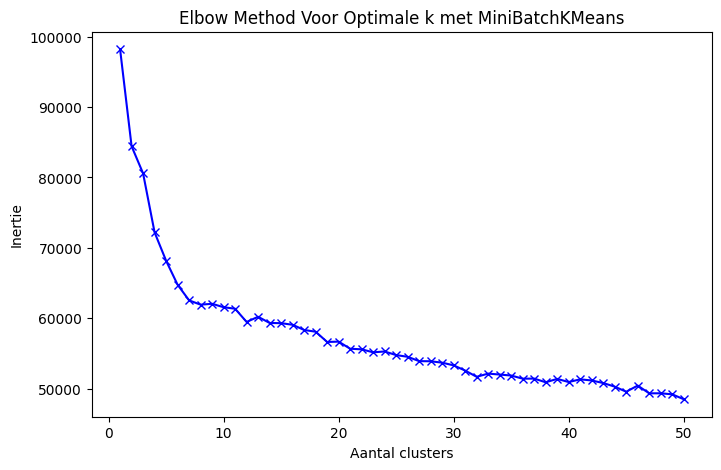

In [37]:
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans

# Bereken inertia voor een bereik van aantal clusters met MiniBatchKMeans
inertia = []
K = range(1, 51)  # Aantal clusters van 1 tot 50
for k in K:
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=100)
    kmeans.fit(dummies_dataframe)
    inertia.append(kmeans.inertia_)

# Plot de elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bx-')
plt.xlabel('Aantal clusters')
plt.ylabel('Inertie')
plt.title('Elbow Method Voor Optimale k met MiniBatchKMeans')
plt.show()